In [48]:
#packages
import pandas as pd
import numpy as np
import matplotlib as plt

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor

In [2]:

# hide warnings
warnings.filterwarnings('ignore')

In [3]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [4]:
def execute_query(connection, query):
    cursor = connection.cursor()
    if query == "":
        return "Query Blank"
    else:
        cursor.execute(query)
        connection.commit()
        return "Query executed successfully"

In [5]:

def create_table(connection, tableName, columns):
    sql = F"DROP TABLE IF EXISTS {tableName}; "
    execute_query(connection, sql)
    sql = F"CREATE TABLE {tableName} ({columns}); "
    return execute_query(connection, sql)


In [6]:

def insert_into_table(connection, table_name, columns, records):
    values = ""
    for record in records:
        record = record.replace("'", "")
        if len(values) > 0:
            values+=","
        if str.isnumeric(record):
            values+= str(record)
        else:
            values +=F"'{record}'"

    sql= F"INSERT INTO {table_name} ({columns}) VALUES ({values}); "
    return execute_query(connection, sql)


In [7]:
import csv

def is_successful( result):
    return "success" in result
    
def import_file(connection, file, table_name, columns):

    with open(file, encoding="utf8") as file:

        lines = csv.reader(file, delimiter=',')
        for line in lines:
                            
            result = insert_into_table(connection, table_name, columns, line)
            if not is_successful(result):
                return result

    return result

In [8]:
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v4.db')


In [9]:
create_table(con, "Truck_Engine_Fire_Station", "Station text, Type text, Unit text, FireStation text, Facility_ID text")


'Query executed successfully'

In [10]:
import_file(con, "C:\\repos\\gatech\\datavisualanalytics\\classproject\\firstrespondersites\\jyEDA\\clean\\truck_engine_fire_station.csv", "truck_engine_fire_station", "Station, Type, Unit, FireStation, Facility_ID")


'Query executed successfully'

In [20]:
def read_data(cpm):
    cur = con.cursor()

    df = pd.read_sql("select floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        ", fire_stations.facility_id " \
        ", category_mappings.[index] as primary_situation_index " \
        ", calls_for_service.case_location " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "left join fire_incidents AS fi on calls_for_service.incident_number = fi.incident_number " \
        "left join category_mappings on fi.primary_situation = category_mappings.primary_situation " \
        "left join Truck_Engine_Fire_Station on calls_for_service.unit_id = Truck_Engine_Fire_Station.Unit " \
        "left join fire_stations on fire_stations.facility_id = Truck_Engine_Fire_Station.Facility_ID " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con) 
    
    return df

In [21]:
df = read_data(con)


In [22]:
 len(df)

137437

In [24]:
def format_columns(df):
    df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
    df['response_dttm'] = pd.to_datetime(df['response_dttm'])
    df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    df['seconds'] = (df.arrival_time.dt.seconds)
    df['day_of_week'] = df['response_dttm'].dt.dayofweek
    df['dayflag'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)
    
    point = df['case_location'].str.split(' ', n = 2, expand = True)
    point_x = point[1].str.split('(', n = 1, expand = True)
    point_y = point[2].str.split(')', n = 1, expand = True)
    
    df['point_x'] = point_x[1]
    df['point_y'] = point_y[0]
    
    return df

In [25]:
df = format_columns(df)

In [26]:
def select_columns(df):
    cols = ['minutes','seconds','response_dttm','on_scene_dttm','day_of_week','dayflag',\
        'zone_idx', 'accessibility_score', 'facility_id', 'primary_situation_index', \
        'arrival_time', 'point_x', 'point_y']
    
    return df[cols]

In [27]:
def prepare_data(df):
    
    df["facility_id"] = pd.to_numeric(df["facility_id"], errors='coerce')
    df["primary_situation_index"] = pd.to_numeric(df["primary_situation_index"], errors='coerce')
    
    #Ignore NaN rows
    df = df[df['minutes'].notna()]
    df = df[df['point_x'].notna()]
    df = df[df['point_y'].notna()]
    df = df[df['facility_id'].notna()]
    df = df[df['primary_situation_index'].notna()]
    
    return df

In [28]:
df = select_columns(df)
df = prepare_data(df)
df.head()

,minutes,seconds,response_dttm,on_scene_dttm,day_of_week,dayflag,zone_idx,accessibility_score,facility_id,primary_situation_index,arrival_time,point_x,point_y
4,1.750000,105.0,2019-01-06 00:52:49,2019-01-06 00:54:34,6.0,False,8,0.000803,716.0,148.0,0 days 00:01:45,-122.507197717067,37.779525347186
5,4.116667,247.0,2019-01-06 00:53:23,2019-01-06 00:57:30,6.0,False,8,0.000803,696.0,148.0,0 days 00:04:07,-122.507197717067,37.779525347186
7,6.816667,409.0,2019-01-14 12:25:54,2019-01-14 12:32:43,0.0,True,8,0.000803,700.0,81.0,0 days 00:06:49,-122.513648358636,37.77848510937
10,2.966667,178.0,2019-01-14 12:41:12,2019-01-14 12:44:10,0.0,True,8,0.000803,698.0,81.0,0 days 00:02:58,-122.513648358636,37.77848510937
11,4.800000,288.0,2019-01-14 12:24:23,2019-01-14 12:29:11,0.0,True,8,0.000803,706.0,81.0,0 days 00:04:48,-122.513648358636,37.77848510937


In [29]:
def configure_sets(md):
    md.target_to_predict = 'minutes'
    md.predictors = ['day_of_week','dayflag', 'zone_idx', 'accessibility_score', 'facility_id', 'primary_situation_index', 'point_x', 'point_y']
    
    md.x = df[md.predictors].values
    md.y = df[md.target_to_predict].values

    #Split the data into training and testing set
    md.x_train, md.x_test, md.y_train, md.y_test = train_test_split(md.x, md.y, test_size=0.8, random_state=42)


In [39]:
def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=4000, subsample=0.9, colsample_bynode=0.2)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('md.ytest', md.y_test)
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')

In [31]:
def cross_validate_model(md):
    # define the model evaluation procedure
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(md.model, md.x, md.y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    # report performance
    print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [33]:
def predict_using_training_set(md):
    prediction = md.XGB.predict(md.x_test)
    
    training_set_predictions = pd.DataFrame(data = md.x_test, columns = md.predictors)
    training_set_predictions[md.target_to_predict] = md.y_test
    training_set_predictions[('Predicted' + md.target_to_predict)] = prediction
    training_set_predictions.head()
    
    print(training_set_predictions)

In [34]:
configure_sets(df)

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.15759538642773618
md.ytest [3.48333333 3.53333333 9.66666667 ... 8.95       3.45       2.78333333]
Accuracy 48.70668792412414
Accuracy -inf


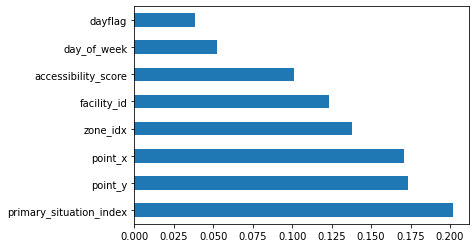

In [40]:

create_model(df)
#cross_validate_model(df)

In [36]:
#cross_validate_model(df)
#MAE: -1.770 (0.152)

MAE: -1.770 (0.152)


In [123]:
df_ag = df.groupby(["zone_idx", "primary_situation_index"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})

In [124]:
df_ag

,zone_idx,primary_situation_index,accessibility_score,minutes
0,8,0.0,0.000803,2.883333
1,8,27.0,0.000803,3.925000
2,8,28.0,0.000803,3.033333
3,8,59.0,0.000803,7.466667
4,8,61.0,0.000803,3.304167
...,...,...,...,...
7517,376,156.0,0.000196,5.333333
7518,376,159.0,0.000196,4.961538
7519,376,161.0,0.000196,5.110000
7520,376,163.0,0.000196,3.550000


<AxesSubplot:>

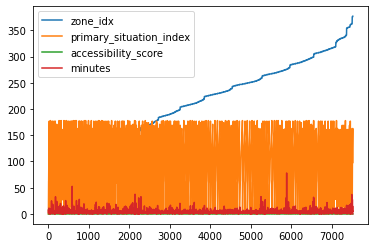

In [125]:
df_ag = df_ag[df_ag['minutes']<100] 
df_ag.plot()


In [126]:
df_ag.target_to_predict = 'minutes'
df_ag.predictors = ['zone_idx', 'accessibility_score']

df_ag.x = df_ag[df_ag.predictors].values
df_ag.y = df_ag[df_ag.target_to_predict].values

df_ag.x_train, df_ag.x_test, df_ag.y_train, df_ag.y_test = train_test_split(df_ag.x, df_ag.y, test_size=0.8, random_state=42)



XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.18169996374612896
md.ytest [ 2.05        3.71111111  9.20625    ...  4.19047619 12.33333333
  5.63611111]
Accuracy 58.60377473932205
Accuracy -inf


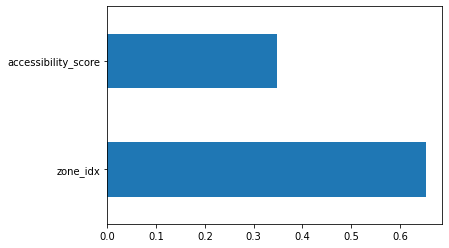

In [127]:
create_model(df_ag)

In [128]:
def predict_single_value(md, row):    
    row = asarray([row])
    
    prediction = md.model.predict(row)
    
    print('Prediction: %f' % prediction[0])

In [136]:
idx = 14
predict_single_value(df_ag, [14, 0.0005012242080398])
df_ag[df_ag['zone_idx']==14]['minutes'].mean()

Prediction: 4.782311


4.714583333333333

,zone_idx,primary_situation_index,accessibility_score,minutes
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,8.0,61.0,8.026153,3.304167
...,...,...,...,...
7517,NaN,NaN,NaN,NaN
7518,NaN,NaN,NaN,NaN
7519,NaN,NaN,NaN,NaN
7520,NaN,NaN,NaN,NaN


In [160]:

cur = con.cursor()
df_baseline = pd.read_sql("select zone_idx, accessibility_score from floating_catchment_output where scenario_name ='baseline'", con=con)


df_baseline.head()


,zone_idx,accessibility_score
0,8,0.000803
1,9,0.001147
2,10,0.000968
3,11,0.000501
4,12,0.000501


In [161]:
prediction = df_ag.XGB.predict(df_baseline)
print(len(prediction))
df_baseline['predicted_minutes'] = prediction

df_baseline.head()


260


,zone_idx,accessibility_score,predicted_minutes
0,8,0.000803,4.178888
1,9,0.001147,3.922159
2,10,0.000968,4.501615
3,11,0.000501,8.776340
4,12,0.000501,4.673000


In [142]:

training_set_predictions = pd.DataFrame(data = df_baseline, columns = df_ag.predictors)
training_set_predictions[df_ag.target_to_predict] = df_ag.y_test
training_set_predictions[('Predicted' + df_ag.target_to_predict)] = prediction

print(df_ag.y_test)

ValueError: Length of values (260) does not match length of index (6016)